In [24]:
import statsmodels.formula.api as smf
import statsmodels.regression.rolling as rolling
import statsmodels.api as sm
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import numpy as np
import pandas as pd

# Load and clean data

In [25]:
two_year = pl.read_parquet('data/two_year.parquet')
equities = pl.read_parquet('data/equities.parquet')

In [26]:
# Merge
df = two_year.join(equities, on=['date'], how='inner')

# Filter
df = (
    df.filter(
        pl.col('date').is_between(date(1993, 1, 29), date.today())
    )
    .sort('date')
)

# Yield change
df = df.with_columns(
    (pl.col('yield').pct_change() * 100).alias('yield_change')
)

# Lag yield change
for i in range(1, 3):
    df = df.with_columns(
        pl.col('yield_change').shift(i).alias(f'yield_change_lag_{i}')
    )

# ETF Return
df = df.with_columns(
    ((pl.col('close') / pl.col('open') - 1) * 100).over('ticker').alias('ret')
)

# Drop columns
df = df.drop(['ticker', 'open', 'close'])

# Drop nulls
df = df.drop_nulls()

df

date,yield,yield_change,yield_change_lag_1,yield_change_lag_2,ret
date,f64,f64,f64,f64,f64
1993-02-03,4.27,0.470588,1.431981,-0.238095,0.914849
1993-02-04,4.19,-1.873536,0.470588,1.431981,0.069493
1993-02-05,4.07,-2.863962,-1.873536,0.470588,0.0
1993-02-08,4.16,2.211302,-2.863962,-1.873536,0.0
1993-02-09,4.2,0.961538,2.211302,-2.863962,-0.348675
…,…,…,…,…,…
2025-02-05,4.17,-0.950119,-1.173709,0.947867,0.596024
2025-02-06,4.21,0.959233,-0.950119,-1.173709,0.054459
2025-02-07,4.29,1.900238,0.959233,-0.950119,-1.008419


# Regression functions

In [27]:
def regression_summary(df: pl.DataFrame, x: str, y: str) -> None:
    formula = f"{y} ~ {x}"
    model = smf.ols(formula=formula, data=df)
    result = model.fit()
    print(result.summary())

In [28]:
def regression_line(df: pl.DataFrame, x: str, y: str) -> tuple[np.array, np.array]:
    # Regression results
    formula = f"{y} ~ {x}"
    result = smf.ols(formula=formula, data=df).fit()

    # Regression line
    intercept, slope = result.params['Intercept'], result.params[x]
    x = np.linspace(df[x].min(), df[x].max())
    y = [intercept + slope * x for x in x]

    return x, y

# Plot functions

In [29]:
def plot_regression_scatter(df: pl.DataFrame, x: str, y: str, regression_line: tuple[np.array, np.array]) -> None:
    x_data, y_data = regression_line

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df[x], df[y], s=10)
    plt.plot(x_data, y_data, color='red')

    plt.title("Effect of Short Term Yield Changes on Market Returns")
    plt.ylabel("S&P 500 Daily Return (%)")
    plt.xlabel("Lagged Daily 2 Year Yield Change (%)")
    
    plt.show()

In [30]:

def rolling_regression(df: pl.DataFrame, x: str, y: str, window: int = 250 * 5) -> pd.DataFrame:
    rolling_df = df.to_pandas()

    # Add constant for intercept
    rolling_df['const'] = 1

    # Fit Rolling OLS
    model = rolling.RollingOLS(rolling_df[y], sm.add_constant(rolling_df[[x]]), window=window)
    results = model.fit()

    # Get rolling coefficients
    rolling_df[f'{x}_coefficient'] = results.params[x]
    rolling_df['intercept_coefficient'] = results.params['const']

    # Get rolling t-stats
    rolling_df[f'{x}_t_stat'] = results.tvalues[x]
    rolling_df['intercept_t_stat'] = results.tvalues['const']

    rolling_df = rolling_df.dropna().reset_index(drop=True)

    return rolling_df

In [31]:
text = 't_stat'
print(text)
print(text.replace("_", '-').title())

t_stat
T-Stat


In [32]:
def plot_rolling_results(rolling_df: pd.DataFrame, slope: str, intercept: str, variable: str) -> None:
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=rolling_df, x='date', y=f"{slope}_{variable}", label=f"{slope.replace('_', '-').title()} {variable.replace('_', '-').title()}")
    sns.lineplot(data=rolling_df, x='date', y=f"{intercept}_{variable}", label=f"{intercept.replace('_', '-').title()} {variable.replace('_', '-').title()}")
    plt.title(f"Rolling 5 Year Regression: {variable.replace('_', '-').title()}")

    plt.xlabel(None)
    plt.ylabel(None)
    plt.legend()

    if variable == 'coefficient':
        plt.yticks(np.arange(-.16, .18, .02))
        plt.axhline(y=0, color='k', ls='--')

    if variable == 't_stat':
        plt.yticks(list(range(-12, 12)))
        plt.axhline(y=-2, color='k', ls='--')    
        plt.axhline(y=2, color='k', ls='--')    

    plt.show()

# No lag results

In [33]:
regression_summary(
    df=df,
    x='yield_change',
    y='ret'
)

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     101.6
Date:                Thu, 13 Feb 2025   Prob (F-statistic):           9.40e-24
Time:                        10:35:49   Log-Likelihood:                -10927.
No. Observations:                7999   AIC:                         2.186e+04
Df Residuals:                    7997   BIC:                         2.187e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0032      0.011      0.304   

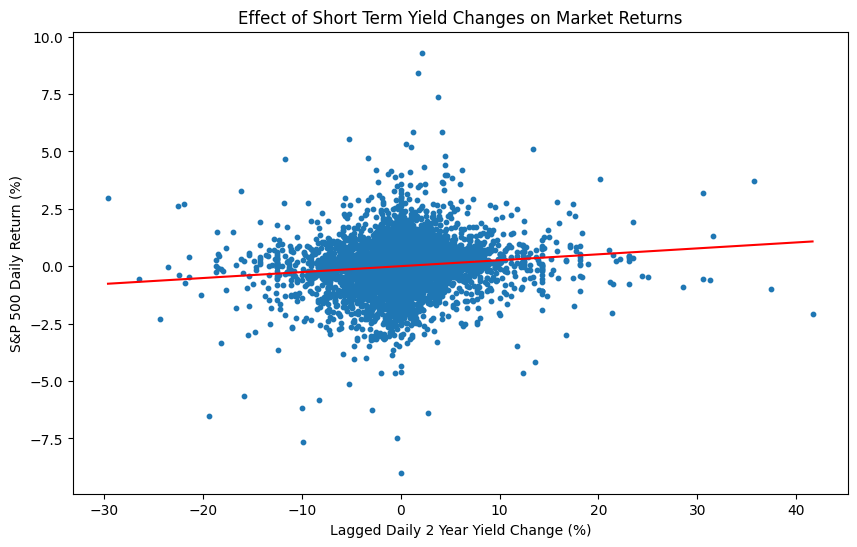

In [34]:
reg_line = regression_line(
    df=df,
    x='yield_change',
    y='ret'  
)

plot_regression_scatter(
    df=df,
    x='yield_change',
    y='ret',
    regression_line=reg_line
)

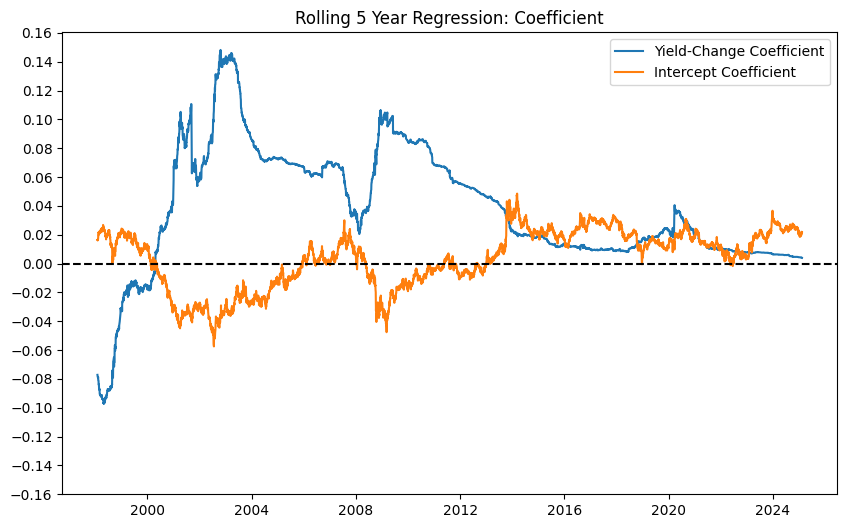

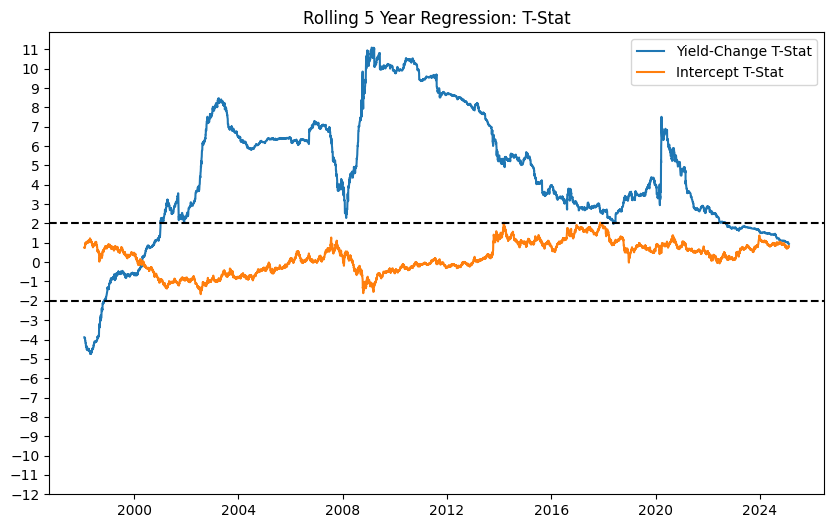

In [35]:
rolling_df = rolling_regression(
    df=df,
    x='yield_change',
    y='ret'
)

plot_rolling_results(
    rolling_df=rolling_df,
    slope='yield_change',
    intercept='intercept',
    variable='coefficient'
)

plot_rolling_results(
    rolling_df=rolling_df,
    slope='yield_change',
    intercept='intercept',
    variable='t_stat'
)

# One day lag results

In [36]:
regression_summary(
    df=df,
    x='yield_change_lag_1',
    y='ret'
)

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     10.68
Date:                Thu, 13 Feb 2025   Prob (F-statistic):            0.00109
Time:                        10:35:50   Log-Likelihood:                -10972.
No. Observations:                7999   AIC:                         2.195e+04
Df Residuals:                    7997   BIC:                         2.196e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0061      0

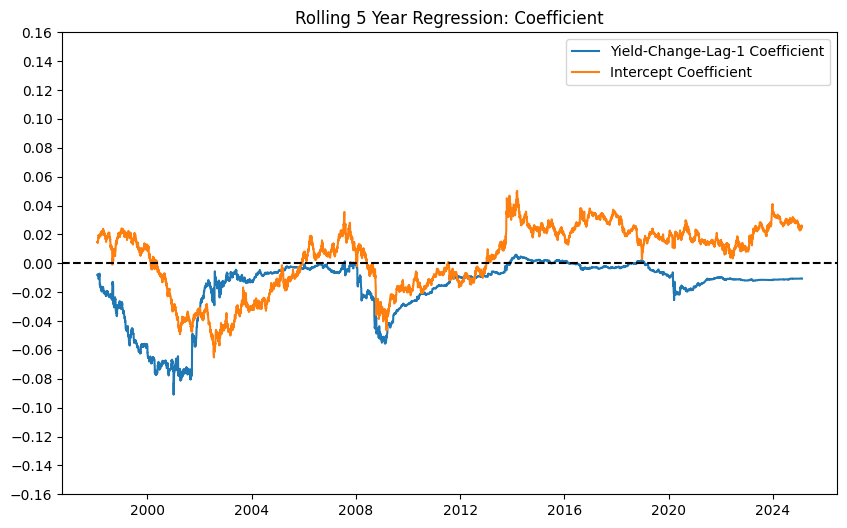

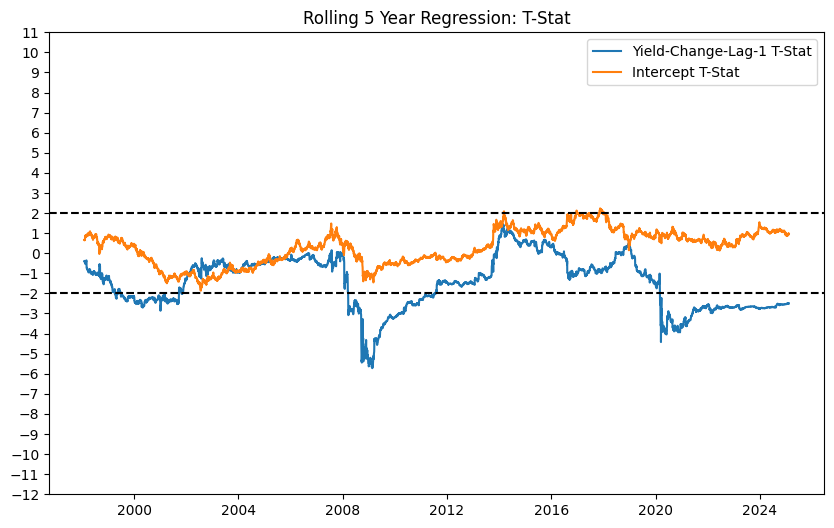

In [37]:
rolling_df = rolling_regression(
    df=df,
    x='yield_change_lag_1',
    y='ret'
)

plot_rolling_results(
    rolling_df=rolling_df,
    slope='yield_change_lag_1',
    intercept='intercept',
    variable='coefficient'
)

plot_rolling_results(
    rolling_df=rolling_df,
    slope='yield_change_lag_1',
    intercept='intercept',
    variable='t_stat'
)

# Two day lag results

In [38]:
regression_summary(
    df=df,
    x='yield_change_lag_2',
    y='ret'
)

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.08478
Date:                Thu, 13 Feb 2025   Prob (F-statistic):              0.771
Time:                        10:35:50   Log-Likelihood:                -10977.
No. Observations:                7999   AIC:                         2.196e+04
Df Residuals:                    7997   BIC:                         2.197e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0054      0

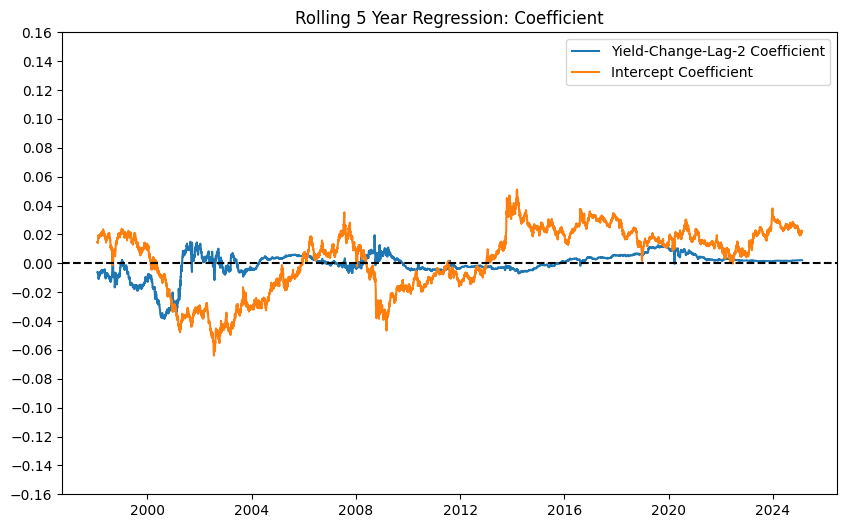

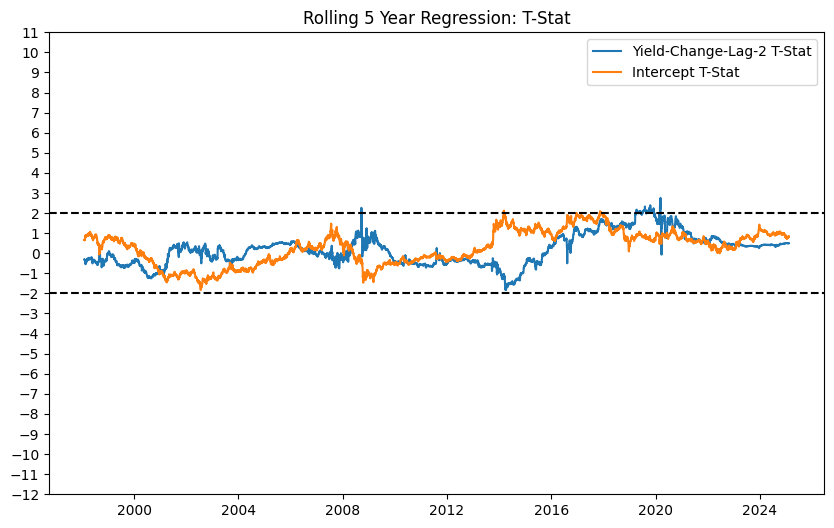

In [39]:
rolling_df = rolling_regression(
    df=df,
    x='yield_change_lag_2',
    y='ret'
)

plot_rolling_results(
    rolling_df=rolling_df,
    slope='yield_change_lag_2',
    intercept='intercept',
    variable='coefficient'
)

plot_rolling_results(
    rolling_df=rolling_df,
    slope='yield_change_lag_2',
    intercept='intercept',
    variable='t_stat'
)